# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

Estado: 200
Se encontraron 26 tablas.
   rank                 song                    artist  streams release_date  \
0     1    "Blinding Lights"                The Weeknd    5.204   2019-11-29   
1     2       "Shape of You"                Ed Sheeran    4.702   2017-01-06   
2     3            "Starboy"  The Weeknd and Daft Punk    4.279   2016-09-21   
3     4    "Sweater Weather"         The Neighbourhood    4.273   2012-12-03   
4     5  "Someone You Loved"             Lewis Capaldi    4.176   2018-11-08   

  scraping_date  
0    2025-12-27  
1    2025-12-27  
2    2025-12-27  
3    2025-12-27  
4    2025-12-27  
Registros en la BD: 100
Datos guardados correctamente.


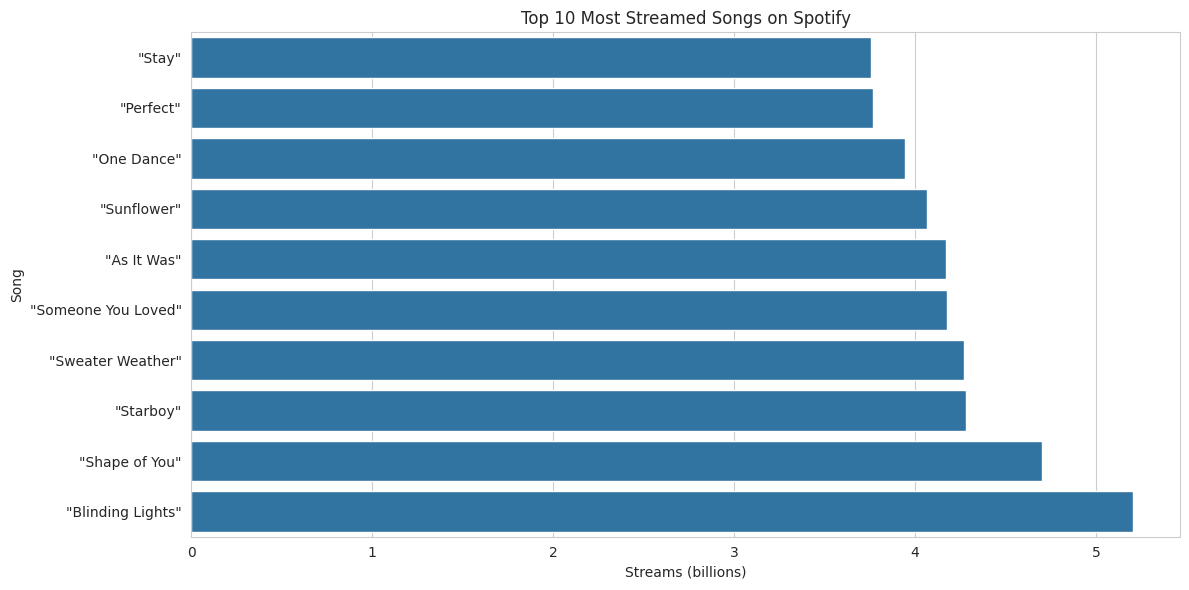

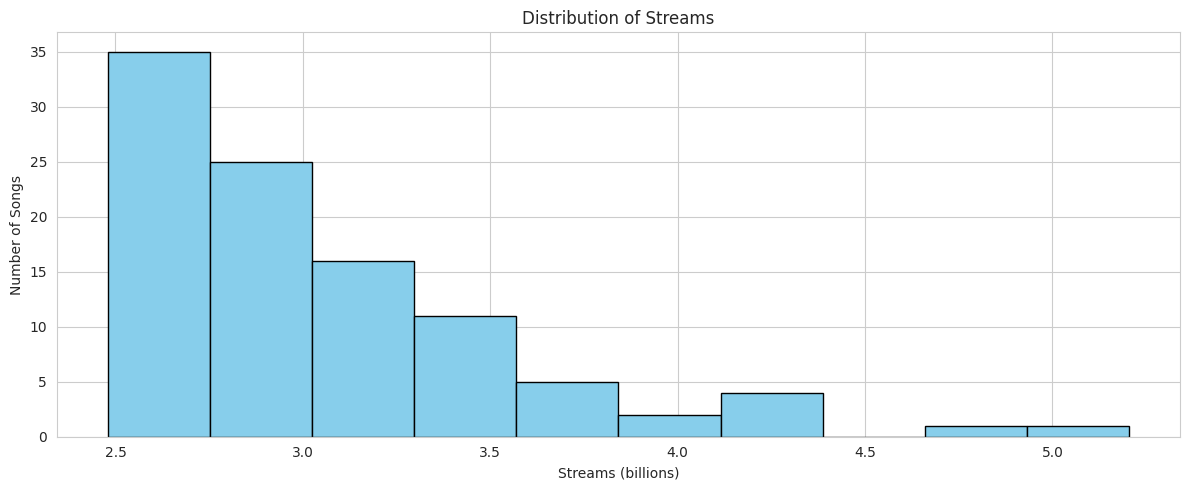

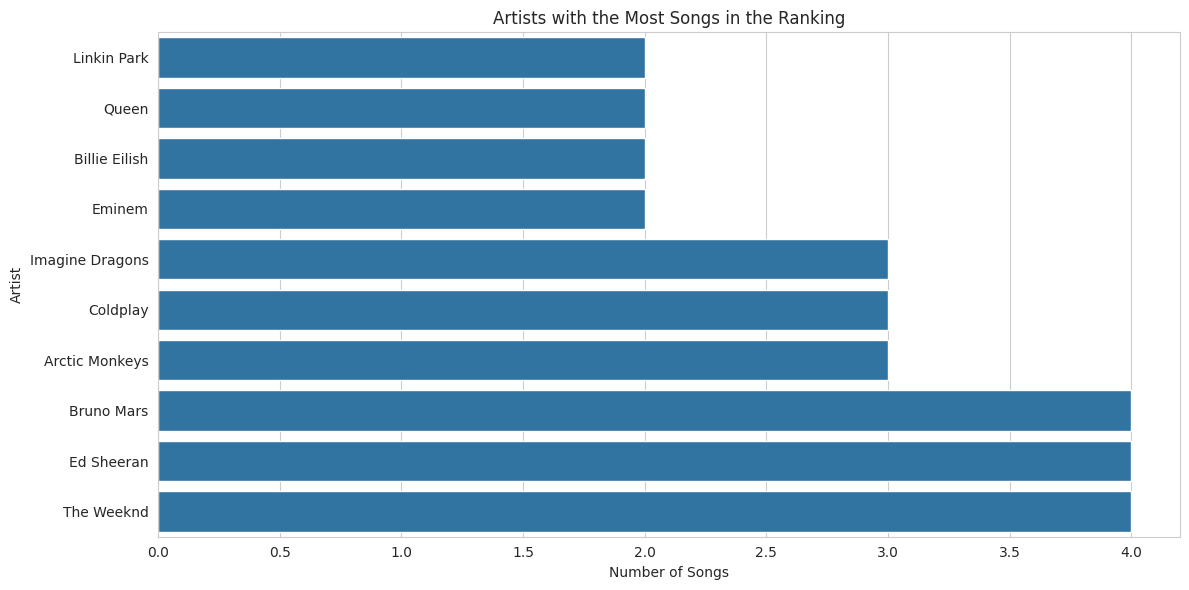

In [88]:
import pandas as pd
import requests
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO


url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36"
}

response = requests.get(url, headers=headers)
print("Estado:", response.status_code)

tablas = pd.read_html(StringIO(response.text))
df = tablas[0].copy()
print("Se encontraron", len(tablas), "tablas.")

df = df[['Rank', 'Song', 'Artist(s)', 'Streams (billions)', 'Release date']].copy()
df.columns = ['rank', 'song', 'artist', 'streams', 'release_date']

df = df[df['rank'].apply(lambda x: str(x).isdigit())]

df["song"] = df["song"].str.replace(r"\[.*?\]", "", regex=True).str.strip()
df["artist"] = df["artist"].str.replace(r"\[.*?\]", "", regex=True).str.strip()

df['rank'] = df['rank'].astype(int)
df['streams'] = (
    df['streams']
    .astype(str)
    .str.replace(',', '')  
    .str.extract(r'(\d+\.?\d*)')[0]
    .astype(float)
)

df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['scraping_date'] = pd.to_datetime(datetime.today().date())

print(df.head())

conn = sqlite3.connect("spotify.db")
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS most_streamed_songs")

cursor.execute("""
CREATE TABLE most_streamed_songs (
    rank INTEGER,
    song TEXT,
    artist TEXT,
    streams REAL,
    release_date TEXT,
    scraping_date TEXT,
    PRIMARY KEY (song, scraping_date)
)
""")

for _, row in df.iterrows():
    cursor.execute("""
    INSERT OR REPLACE INTO most_streamed_songs
    (rank, song, artist, streams, release_date, scraping_date)
    VALUES (?, ?, ?, ?, ?, ?)
    """, (
        row['rank'],
        row['song'],
        row['artist'],
        row['streams'],
        row['release_date'].strftime("%Y-%m-%d") if pd.notnull(row['release_date']) else None,
        row['scraping_date'].strftime("%Y-%m-%d")
    ))

conn.commit()
cursor.execute("SELECT COUNT(*) FROM most_streamed_songs")
print("Registros en la BD:", cursor.fetchone()[0])
conn.close()
print("Datos guardados correctamente.")

df_plot_clean = df.drop(columns=['scraping_date'])

sns.set_style("whitegrid")

top10 = df_plot_clean.sort_values(by="streams", ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(
    x='streams',
    y='song',
    data=top10,
)
plt.xlabel("Streams (billions)")
plt.ylabel("Song")
plt.title("Top 10 Most Streamed Songs on Spotify")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(df_plot_clean["streams"], bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Streams (billions)")
plt.ylabel("Number of Songs")
plt.title("Distribution of Streams")
plt.tight_layout()
plt.show()

artists = df_plot_clean['artist'].value_counts().head(10).sort_values()

plt.figure(figsize=(12,6))
sns.barplot(
    x=artists.values,
    y=artists.index,
)
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.title("Artists with the Most Songs in the Ranking")
plt.tight_layout()
plt.show()
